In [1]:
import os  

# dont do this in production
os.environ["MLFLOW_TRACKING_USERNAME"] = "admin"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "password"
os.environ["MLFLOW_ENABLE_SYSTEM_METRICS_LOGGING"] = "true"
os.environ["AWS_DEFAULT_REGION"] = "eu-west-3"
os.environ["AWS_REGION"] = "eu-west-3"
os.environ["AWS_ACCESS_KEY_ID"] = "admin"
os.environ["AWS_SECRET_ACCESS_KEY"] = "test_password"
os.environ["MLFLOW_S3_ENDPOINT_URL"] = "http://172.24.5.222:9020"
# tracking uri
os.environ["MLFLOW_TRACKING_URI"] = "https://ard-mlflow.slac.stanford.edu"



from mlflow import MlflowClient

from mlflow.server import get_app_client
import mlflow.pytorch
import mlflow.keras
import mlflow
from mlflow.models import infer_signature

import matplotlib.pyplot as plt

import keras
import torch

import numpy as np
import pandas as pd

mlflow.set_experiment("my-experiment")

data_X = np.random.uniform(-1, 1, (1000, 2))
data_y = np.max(data_X, axis=1)

2024/03/25 11:16:18 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: `pynvml` is not installed, to log GPU metrics please run `pip install pynvml` to install it..
2024/03/25 11:16:18 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
2024/03/25 11:16:32 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/03/25 11:16:32 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


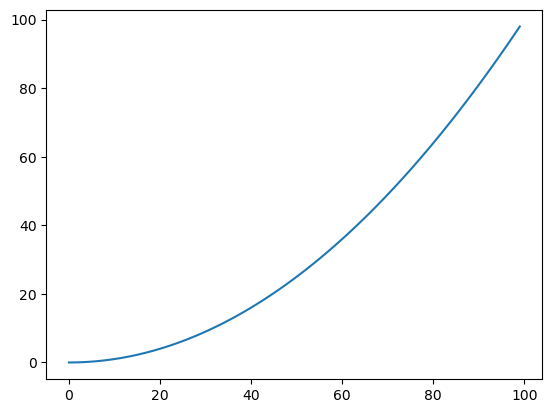

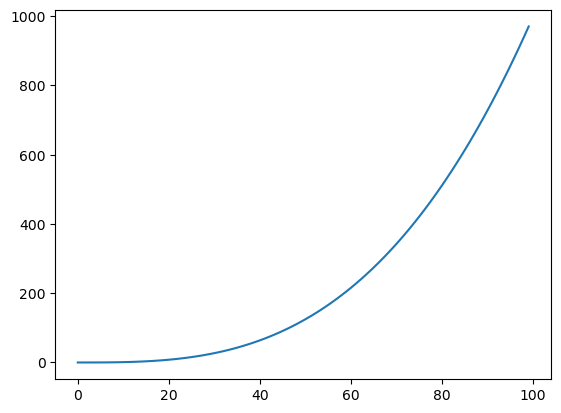

In [19]:
# generic 

class MyModel(mlflow.pyfunc.PythonModel):
    def __init__(self, model_name):
        self.model_name = model_name

    # this function is called when the model is loaded using pyfunc.load_model
    def predict(self, context, input, **kwargs):
        return self.predict_internal(input, **kwargs)

    # this function is the true predic function, but we need the context parameter to be able to use the model with mlflow
    def predict_internal(self, input, **kwargs):
        return np.max(input, axis=1)

    def inverse_predict_internal(self, input, **kwargs):
        return np.sqrt(input)

    def save_model(self):
        with open(f"{self.model_name}.txt", "w") as f:
            f.write("model saved")

    def load_model(self):
        with open(f"{self.model_name}.txt", "r") as f:
            return f.read()
        
    def unwrap_python_model(self):
        return self.lume_model
    
    def make_serializable(self, model):
        return model
    
model = MyModel("model1")

with mlflow.start_run() as run:  # you can use run_name="test1" to give a name to the run otherwise it will a random name

    
    # set some tags for the experiment
    mlflow.set_tag("exp_tag1", "exp_tag_value1")
    mlflow.set_tag("exp_tag2", "exp_tag_value2")
    mlflow.set_tag("exp_tag3", "exp_tag_value3")

    model = MyModel("model1")
    input_sample = np.random.uniform(-1, 1, (100, 2))
    # model.save_model() # no need to save the model since it is saved in log_model
    mlflow.log_param("model_name", model.model_name)
    mlflow.log_param("dummy_param1", "dummy_value1")
    mlflow.log_param("dummy_param2", 0.33)
    for i in range(10):        
        mlflow.log_metric("metric1", (i / 10) ** 2 , step=i)
        mlflow.log_metric("metric2", (i / 10) ** 3 , step=i)
        mlflow.log_metric("loss", (1 / (i + 0.1) + np.random.normal(0, 0.1)) , step=i)

    # lets make some pretty graphs to store

    graph = plt.figure()
    plt.plot(range(100), [(i / 10) ** 2 for i in range(100)])
    mlflow.log_figure(graph, "figures/metric1.png")

    # alternative way to log a figure
    graph = plt.figure()
    plt.plot(range(100), [(i / 10) ** 3 for i in range(100)])
    graph.savefig("metric2.png")
    mlflow.log_artifact("metric2.png", artifact_path="figures")
    
    
    model_info = mlflow.pyfunc.log_model(
        artifact_path="model_files",
        python_model=model,
        signature=infer_signature(input_sample, model.predict_internal(input_sample)),
        input_example=input_sample,
        # registered_model_name="mo
        # del1",  # this will automatically register the model and iterate the version
     )

    # if you wanna log the model without the wrapper
    model.save_model()
    mlflow.log_artifact(
        f"{model.model_name}.txt", artifact_path="model_files_no_mlflow"
    )

    # set some tags

In [20]:
# keras model

inputs = [keras.Input(name="input1", shape=(1,)), keras.Input(name="input2", shape=(1,))]
x = keras.layers.concatenate(inputs)
x1 = keras.layers.Dense(64, activation='relu')(x)
x2 = keras.layers.Dense(64, activation='relu')(x1)
outputs = keras.layers.Dense(1, name="output")(x2)
model_keras = keras.Model(inputs=inputs, outputs=outputs)

mlflow.keras.autolog(log_models=False)
with mlflow.start_run() as run:
    model_keras.compile(optimizer='adam', loss='mean_squared_error')
    model_keras.fit([data_X[:, 0], data_X[:, 1]], data_y, epochs=10)
    mlflow.set_tag("tag1", "tag_value1")
    signature = infer_signature(data_X, model_keras.predict([data_X[:, 0], data_X[:, 1]]))
    model_info_keras = mlflow.keras.log_model(model_keras, "keras_model", signature=signature)

2024/03/25 11:16:33 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of keras. If you encounter errors during autologging, try upgrading / downgrading keras to a supported version, or try upgrading MLflow.
2024/03/25 11:16:33 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: `pynvml` is not installed, to log GPU metrics please run `pip install pynvml` to install it..
2024/03/25 11:16:33 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
2024/03/25 11:16:33 WARNING mlflow.keras.autologging: Unrecognized dataset type <class 'list'>. Dataset logging skipped.


Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.1771 
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0091 
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0026 
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0014 
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.2564e-04
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.8049e-04 
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.2480e-04
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1275e-04 
Epoch 9/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5456e-04 
Epoch 10/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1164e-04 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2024/03/25 11:16:58 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/03/25 11:16:58 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


In [21]:

# torch model 
model_torch = torch.nn.Sequential(
    torch.nn.Linear(2, 64),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 1),
    torch.nn.Linear(1, 1)
)

mlflow.pytorch.autolog()
with mlflow.start_run() as run:
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model_torch.parameters(), lr=0.01)#
    batch_size = 1000
    # log params
    mlflow.log_param("lr", 0.01)
    mlflow.log_param("optimizer", "Adam")
    mlflow.log_param("loss", "MSELoss")
    mlflow.log_param("batch_size", batch_size)
    
    for t in range(10):
        losses = []
        for i in range(0, len(data_X), batch_size):
            X = torch.tensor(data_X[i:i+batch_size], dtype=torch.float32)
            y = torch.tensor(data_y[i:i+batch_size], dtype=torch.float32)
            y_pred = model_torch(X)
            
            loss = criterion(y_pred, y)
            optimizer.zero_grad()
            
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        mlflow.log_metric("loss", np.mean(losses), step=t)
        print(t, np.mean(losses))
    
    mlflow.set_tag("tag1", "tag_value1")
        
        
    signature = infer_signature(data_X, model_torch(torch.tensor(data_X, dtype=torch.float32)).detach().numpy()) # optional but useful

    model_info_torch = mlflow.pytorch.log_model(model_torch, "torch_model", signature=signature)

2024/03/25 11:16:58 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: `pynvml` is not installed, to log GPU metrics please run `pip install pynvml` to install it..
2024/03/25 11:16:58 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
c:\Users\gbm96348\AppData\Local\miniconda3\envs\mlflow\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1000])) that is different to the input size (torch.Size([1000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


0 0.8203675746917725
1 0.5591278672218323
2 0.3585895597934723
3 0.23891310393810272
4 0.27390751242637634
5 0.34860002994537354
6 0.3286738693714142
7 0.2735525071620941
8 0.23709172010421753
9 0.23090201616287231


2024/03/25 11:17:13 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/03/25 11:17:14 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


In [41]:
# specifc model uris
print(model_info.model_uri)
print(model_info_keras.model_uri)
print(model_info_torch.model_uri)

# lets register the models
client = MlflowClient()
try:
    client.create_registered_model("generic_model")
    
except:
    pass

try:
    client.create_registered_model("keras_model")
except:
    pass

try:
    client.create_registered_model("torch_model")
except:
    pass

# register the models
result_generic = client.create_model_version(
    name="generic_model",
    source=model_info.model_uri,
    run_id=model_info.run_id,
    tags={"tests": "pending", "framework": "pyfunc"},
)


result_keras = client.create_model_version(
    name="keras_model",
    source=model_info_keras.model_uri,
    run_id=model_info_keras.run_id,
)



result_torch = client.create_model_version(
    name="torch_model",
    source=model_info_torch.model_uri,
    run_id=model_info_torch.run_id,
)

client.set_registered_model_alias("generic_model", "challenger", result_generic.version)


client.set_registered_model_tag("generic_model", "lattice_component", "ABC")
client.set_registered_model_tag("generic_model", "lume_service", "false")
client.set_registered_model_tag("generic_model", "lume_service_url", "")
client.set_registered_model_tag("generic_model", "deployment_type", "continuous")
client.set_registered_model_tag("generic_model", "multi_model_service", "false")
client.set_registered_model_tag("generic_model", "retrain", "false")
client.set_registered_model_tag("generic_model", "retrain_endpoint", "")

# do some tests
model_ver_champ = client.get_model_version_by_alias("generic_model", "challenger").version

# 50% of the time it will pass
if np.random.uniform() > 0.5:
    client.set_model_version_tag("generic_model", f"{model_ver_champ}", "tests", "passed")
    # set the champion model
    client.set_registered_model_alias("generic_model", "champion", result_generic.version)
else:
    client.set_model_version_tag("generic_model", f"{model_ver_champ}", "tests", "failed")
    print("model failed")


# other model stuff

client.set_registered_model_alias("keras_model", "champion", result_keras.version)

client.set_registered_model_alias("torch_model", "champion", result_torch.version)




runs:/1fa10b9f63294fada6b759583a1152bf/model_files
runs:/2e92afcd988e41e09670e028017a5059/keras_model
runs:/255af0190fb94b348098ddd93510af92/torch_model


2024/03/25 11:39:42 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: generic_model, version 41
2024/03/25 11:39:42 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: keras_model, version 39
2024/03/25 11:39:42 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: torch_model, version 40


model failed


In [30]:
# get model ids from registered models
genric_model  = mlflow.pyfunc.load_model(f"models:/generic_model@champion")
keras_model = mlflow.keras.load_model(f"models:/keras_model@champion")
torch_model = mlflow.pytorch.load_model(f"models:/torch_model@champion")

# get model info
print("Generic model")
print(genric_model, type(genric_model))
print("Keras model")
print(keras_model, type(keras_model))
print("Torch model")
print(torch_model, type(torch_model))

new_data = np.random.uniform(-1, 1, (2, 2))
print(new_data)

# lets run some predictions

print("Generic model")
print(genric_model.predict(new_data))
print("Keras model")
print(keras_model.predict([new_data[:, 0], new_data[:, 1]]))
print("Torch model")
print(torch_model(torch.tensor(new_data, dtype=torch.float32)).detach().numpy())


2024/03/25 11:22:22 INFO mlflow.store.artifact.artifact_repo: The progress bar can be disabled by setting the environment variable MLFLOW_ENABLE_ARTIFACTS_PROGRESS_BAR to false


2024/03/25 11:22:23 INFO mlflow.store.artifact.artifact_repo: The progress bar can be disabled by setting the environment variable MLFLOW_ENABLE_ARTIFACTS_PROGRESS_BAR to false


2024/03/25 11:22:24 INFO mlflow.store.artifact.artifact_repo: The progress bar can be disabled by setting the environment variable MLFLOW_ENABLE_ARTIFACTS_PROGRESS_BAR to false


Generic model
mlflow.pyfunc.loaded_model:
  artifact_path: model_files
  flavor: mlflow.pyfunc.model
  run_id: 1fa10b9f63294fada6b759583a1152bf
 <class 'mlflow.pyfunc.PyFuncModel'>
Keras model
mlflow.pyfunc.loaded_model:
  artifact_path: keras_model
  flavor: mlflow.keras
  run_id: 2e92afcd988e41e09670e028017a5059
 <class 'mlflow.pyfunc.PyFuncModel'>
Torch model
mlflow.pyfunc.loaded_model:
  artifact_path: torch_model
  flavor: mlflow.pytorch
  run_id: 255af0190fb94b348098ddd93510af92
 <class 'mlflow.pyfunc.PyFuncModel'>
[[-0.61803124 -0.999178  ]
 [-0.8564525  -0.64729058]]
Generic model
[-0.61803124 -0.64729058]
Keras model


MlflowException: Failed to enforce schema of data '[array([-0.61803124, -0.8564525 ]), array([-0.999178  , -0.64729058])]' with schema '[Tensor('float64', (-1, 2))]'. Error: This model contains a tensor-based model signature with no input names, which suggests a numpy array input or a pandas dataframe input with proper column values, but an input of type <class 'list'> was found.

In [ ]:
# We can create a wrapper for these models into lume-models
from lume_model.base import LUMEBaseModel
from lume_model.variables import ScalarInputVariable, ScalarOutputVariable
import torch
import keras

class ExampleModel(LUMEBaseModel):
    model: torch.nn.modules.container.Sequential
    
    # keras model
    # model: keras.Model
    # def evaluate(self, input_dict):

    #     input1 = np.array(input_dict["input1"])
    #     input2 = np.array(input_dict["input2"])
    #     output = self.model_predict([input1, input2])
    #     output_dict = {"output1": output}
    #     return output_dict
    
    # generic model
    # model: mlflow.pyfunc.PyFuncModel
    # def evaluate(self, input_dict):
    #     # input_dict is a dictionary with the input variable names as keys
    #     input = np.array([input_dict["input1"], input_dict["input2"]])
    #     input = input.reshape(len(input_dict["input1"]), -1)
    #     output = self.model.predict(input)
    #     output = output.reshape(-1).tolist()
    #     output_dict = {"output1": output}
    #     return output_dict

    # torch model
    model: torch.nn.modules.container.Sequential
    def evaluate(self, input_dict):
        input = torch.tensor([input_dict["input1"], input_dict["input2"]], dtype=torch.float32)
        input = input.reshape(len(input_dict["input1"]), -1)
        output = self.model(input)
        output = output.detach().numpy().reshape(-1).tolist()
        output_dict = {"output1": output}
        return output_dict
    
input_variables = [
    ScalarInputVariable(name="input1", default=0.1, value_range=[0.0, 1.0]),
    ScalarInputVariable(name="input2", default=0.2, value_range=[0.0, 1.0]),
]
output_variables = [
    ScalarOutputVariable(name="output1"),
]

m = ExampleModel(input_variables=input_variables, output_variables=output_variables, model=torch_model)

input_dict = {
    "input1": [0.3,0.2,-0.2],
    "input2": [0.1,0.16,-0.1],
}
print(m.evaluate(input_dict))

{'output1': [0.2212391197681427, 0.19697442650794983, 0.20531699061393738]}


In [ ]:
!conda activate mlflow
!python -V

Python 3.11.8
